## Timing of photutils.datasets.make_gaussian_sources as a function of image size and number of sources. 


For a range of image sizes and a range of source counts, time the execution of photutils.datasets.make_gaussian_sources and take the average of 10. Run iterations in parallel to speed things up. 

Specify the number of cores, range of image sizes, range of source counts, the number of samples, and default gaussian parameters. For now all sources are the same and symmetric.

In [71]:
% matplotlib inline

import numpy as np
import time
import multiprocessing as mp
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from photutils.datasets import make_gaussian_sources
from astropy import table
import timeit

In [64]:
N_core = 10

min_size = 128
max_size = 512
min_sources = 1
max_sources = 200
N_samples = 20

std0 = 3.
flux0 = 10.
theta0 = 0.

In [65]:
image_size = np.linspace(min_size,max_size,N_samples).astype(int)
image_size

array([128, 148, 168, 188, 208, 229, 249, 269, 289, 309, 330, 350, 370,
       390, 410, 431, 451, 471, 491, 512])

In [66]:
N_sources = np.linspace(min_sources,max_sources,N_samples).astype(int)
N_sources

array([  1,  11,  21,  32,  42,  53,  63,  74,  84,  95, 105, 116, 126,
       137, 147, 158, 168, 179, 189, 200])

In [67]:
def gen_source_table(imsize, nsrc):
    data = {}
    data['x_mean'] = np.random.rand(nsrc)*imsize
    data['y_mean'] = np.random.rand(nsrc)*imsize
    data['flux'] = np.ones(nsrc)*flux0
    data['x_stddev'] = np.ones(nsrc)*std0
    data['y_stddev'] = np.ones(nsrc)*std0
    data['theta'] = np.zeros(nsrc)
    return table.Table(data)

In [68]:
def wrapper(func, *args, **kwargs):
     def wrapped():
        return func(*args, **kwargs)
     return wrapped

In [69]:
def timing_fun(ij):
    i,j = ij
    s = image_size[i]
    n = N_sources[j]
    tab= gen_source_table(s,n)
    wrapped = wrapper(make_gaussian_sources,(s,s),tab)
    t = np.mean(timeit.repeat(wrapped,number=1,repeat=10))
    return(t)

In [70]:
i,j = np.meshgrid(range(len(image_size)),range(len(N_sources)))
ijs=zip(i.flatten(),j.flatten())
t1=time.time()
pool=mp.Pool(N_core)
result=pool.map(timing_fun,ijs)
pool.close()
t2=time.time()
print (t2-t1)/60.,' minutes to run all iterations on ',str(N_core),' cores.'

18.1590631803  minutes to run all iterations on  10  cores.


In [72]:
times = np.empty((len(image_size),len(N_sources)))
for k,(i,j) in enumerate(ijs): times[i,j] = result[k]

<matplotlib.colorbar.Colorbar instance at 0x7f3690619440>

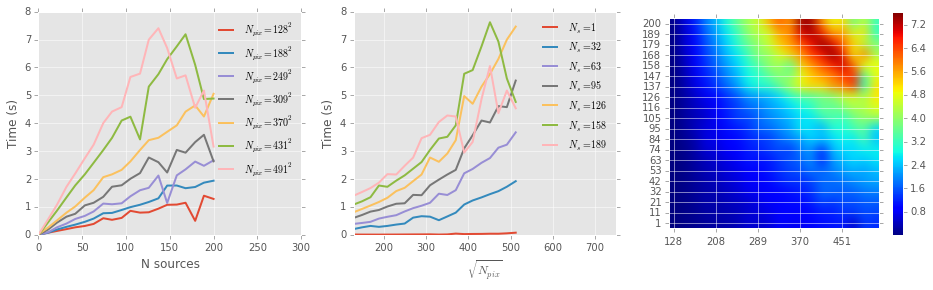

In [82]:
plt.figure(figsize=(16,4))
plt.subplot(131)
for i in range(len(image_size))[::3]: plt.plot(N_sources,times[i,:],label='$N_{pix}='+str(int(image_size[i]))+'^2$',lw=2)
plt.legend(frameon=False,fontsize=10)
plt.xlabel('N sources')
plt.ylabel('Time (s)')
plt.xlim(0,300)
plt.subplot(132)
for i in range(len(N_sources))[::3]: plt.plot(image_size,times[:,i],label='$N_s='+str(int(N_sources[i]))+'$',lw=2)
plt.legend(frameon=False)
plt.xlabel('$\sqrt{N_{pix}}$')
plt.ylabel('Time (s)')
plt.legend(frameon=False,fontsize=10)
plt.xlim(128,750)
plt.subplot(133)
plt.imshow(times,origin='lower',interpolation='bicubic')
plt.xticks(range(0,20,4),image_size[::4])
plt.yticks(range(20),N_sources)
plt.colorbar()